In [ ]:
import os, math, json, random, numpy as np, pandas as pd
import geopandas as gpd, networkx as nx, folium, osmnx as ox
from shapely.geometry import Point, LineString
import torch, torch.nn as nn, torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, GraphConv, global_mean_pool
from tqdm.auto import tqdm

/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3

In [ ]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# City slice
CITY = "Manhattan, New York, USA"
BOUND_BOX = None  # e.g., (north, south, east, west) for ox.graph_from_bbox if you want a smaller cut

# Building drive + walk graph with OSMnx, merge, and project
print("Downloading OSM…")
G_drive = ox.graph_from_place(CITY, network_type="drive", simplify=True)
G_walk  = ox.graph_from_place(CITY, network_type="walk",  simplify=True)
G = nx.compose(G_drive, G_walk)   # both are already simplified

# Keeping two versions: projected (meters) and lat/lon
G_proj = ox.project_graph(G)  # for lengths
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
nodes_ll = ox.graph_to_gdfs(G, nodes=True, edges=False)

In [ ]:
# Normalize node ids & add elevation (SRTM)
print("Adding elevation (SRTM)… (first run caches tiles)")
nodes_proj = nodes_proj.reset_index().rename(columns={"osmid":"id"})
nodes_ll   = nodes_ll.reset_index().rename(columns={"osmid":"id"})
nodes_ll["lat"] = nodes_ll.geometry.y
nodes_ll["lon"] = nodes_ll.geometry.x

import srtm
elev_data = srtm.get_data()
def elev(lat, lon):
    try:
        v = elev_data.get_elevation(float(lat), float(lon))
        return float(v) if v is not None else 0.0
    except:
        return 0.0

nodes_ll["elev_m"] = nodes_ll[["lat","lon"]].apply(lambda r: elev(r.lat, r.lon), axis=1)

# Join elevation back onto projected nodes
nodes_gdf = nodes_proj.merge(nodes_ll[["id","elev_m"]], on="id", how="left")



Adding elevation (SRTM)… (first run caches tiles)
Creating /root/.cache/srtm
4 25934402
4 25934402


In [ ]:
# Rebuild edges_gdf with u,v present and recompute features

# Keep u,v,key as columns (NO drop=True!)
edges_gdf = edges_proj.reset_index().copy()   # <-- this preserves 'u','v','key'

# Ensure node ids are ints
edges_gdf["u"] = edges_gdf["u"].astype(int)
edges_gdf["v"] = edges_gdf["v"].astype(int)

# Length already in meters (projected graph)
edges_gdf["length_m"] = edges_gdf["length"].astype(float)

# Simple walk time proxy
edges_gdf["time_s"] = edges_gdf["length_m"] / 1.3

# Slope from node elevations
nid2elev = nodes_gdf.set_index("id")["elev_m"].to_dict()

def slope_pct(row):
    dz = float(nid2elev.get(row["v"], 0.0) - nid2elev.get(row["u"], 0.0))
    L  = max(1.0, float(row["length_m"]))
    return 100.0 * dz / L

edges_gdf["slope_pct"] = edges_gdf.apply(slope_pct, axis=1)

# sanity
print("edges_gdf has u,v?", {"u","v"}.issubset(edges_gdf.columns))
print(edges_gdf[["u","v","length_m","time_s","slope_pct"]].head())


edges_gdf has u,v? True
          u         v    length_m      time_s  slope_pct
0  42421728  42435337   85.345155   65.650119   4.686851
1  42421728  42421731  138.033090  106.179300   4.346784
2  42421728  42432736   86.274316   66.364858  -3.477281
3  42435337  42437916  137.996672  106.151286   2.173965
4  42435337  42421728   85.345155   65.650119  -4.686851


In [ ]:
# PyTorch Geometric tensors
node_ids = nodes_gdf["id"].tolist()
nid2ix   = {nid:i for i, nid in enumerate(node_ids)}

src = edges_gdf["u"].map(nid2ix).astype(int).values
dst = edges_gdf["v"].map(nid2ix).astype(int).values
edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

# Node features: (x,y,elev) from projected CRS centroid for stability
nodes_gdf["x"] = nodes_gdf.geometry.x
nodes_gdf["y"] = nodes_gdf.geometry.y
X_nodes = torch.tensor(nodes_gdf[["x","y","elev_m"]].fillna(0).values, dtype=torch.float32)

# Edge features: (length, time, slope)
E_edges = torch.tensor(edges_gdf[["length_m","time_s","slope_pct"]].fillna(0).values, dtype=torch.float32)

data = Data(x=X_nodes, edge_index=edge_index, edge_attr=E_edges)

# Build a NetworkX view with weights for sim/baselines
Gnx = nx.DiGraph()
for i, e in edges_gdf.iterrows():
    Gnx.add_edge(int(e.u), int(e.v),
                 eid=i,
                 time_s=float(e.time_s),
                 length_m=float(e.length_m),
                 slope_pct=float(e.slope_pct))

In [ ]:
# Simulate trips (time-optimal baseline paths)
def shortest_edge_path(u_id, v_id, weight="time_s"):
    try:
        npath = nx.shortest_path(Gnx, source=int(u_id), target=int(v_id), weight=weight, method="dijkstra")
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return [], []
    epath = []
    for a, b in zip(npath[:-1], npath[1:]):
        edata = Gnx.get_edge_data(a, b)
        if edata and "eid" in edata: epath.append(edata["eid"])
    return npath, epath

def random_node():
    return random.choice(node_ids)

TRIPS = []
target_trips = 1200  # keep small for CPU speed
pbar = tqdm(total=target_trips, desc="Simulating trips")
attempts = 0
while len(TRIPS) < target_trips and attempts < target_trips*10:
    attempts += 1
    s_id, t_id = random_node(), random_node()
    if s_id == t_id: continue
    nodes_path, edge_path = shortest_edge_path(s_id, t_id, weight="time_s")
    if len(edge_path) >= 3:
        TRIPS.append({"src": s_id, "dst": t_id, "edge_seq": edge_path, "node_seq": nodes_path})
        pbar.update(1)
pbar.close()
print("Trips:", len(TRIPS))

Simulating trips:   0%|          | 0/1200 [00:00<?, ?it/s]

Trips: 1200


In [ ]:
# Precompute tensors for fast edge lookups
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

u_idx_t = torch.tensor(edges_gdf["u"].map(nid2ix).values, dtype=torch.long, device=device)
v_idx_t = torch.tensor(edges_gdf["v"].map(nid2ix).values, dtype=torch.long, device=device)
edge_attr_t = torch.tensor(
    edges_gdf[["length_m","time_s","slope_pct"]].values, dtype=torch.float32, device=device
)

data = data.to(device)

In [ ]:
# GNN model: node encoder + edge scoring head
class EdgeScorerFast(nn.Module):
    def __init__(self, in_node=3, in_edge=3, hid=64):
        super().__init__()
        from torch_geometric.nn import GATv2Conv
        self.conv1 = GATv2Conv(in_node, hid, heads=2, concat=True, edge_dim=in_edge)
        self.conv2 = GATv2Conv(hid*2, hid, heads=1, concat=True, edge_dim=in_edge)
        self.edge_mlp = nn.Sequential(
            nn.Linear(hid*2 + in_edge, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index, edge_attr=data.edge_attr); x = F.elu(x)
        x = self.conv2(x, data.edge_index, edge_attr=data.edge_attr);     x = F.elu(x)
        return x
    def score_edge_ids(self, node_emb, eids_flat):
        # eids_flat: (B*C,) LongTensor of edge IDs
        u = u_idx_t[eids_flat]
        v = v_idx_t[eids_flat]
        eattr = edge_attr_t[eids_flat]
        feat = torch.cat([node_emb[u], node_emb[v], eattr], dim=1)
        return self.edge_mlp(feat).squeeze(-1)   # (B*C,)

model = EdgeScorerFast(in_node=data.x.shape[1], in_edge=data.edge_attr.shape[1]).to(device)


In [ ]:
# Freeze encoder for speed; we train the edge scorer first.
for p in model.conv1.parameters(): p.requires_grad = False
for p in model.conv2.parameters(): p.requires_grad = False

opt = torch.optim.AdamW(model.edge_mlp.parameters(), lr=5e-4, weight_decay=1e-4)

# Compute node embeddings ONCE (since encoder is frozen)
with torch.no_grad():
    node_emb_static = model(data).detach()


In [ ]:
def ensure_fast_scorer(model):
    # must expose score_edge_ids(node_emb, eids_flat: LongTensor)->(B*C,)
    assert hasattr(model, "score_edge_ids"), "Model must define score_edge_ids for vectorized training."
ensure_fast_scorer(model)

In [ ]:
# HARD NEGATIVES (time-similar)

CAND_K = 8  # fixed candidate set size
# Build adjacency: node -> outgoing edge ids
nid2out_eids = {}
for i, e in edges_gdf.iterrows():
    nid2out_eids.setdefault(int(e.u), []).append(int(i))

samples = []
for trip in TRIPS:
    epath = trip["edge_seq"]
    for j in range(len(epath)-1):
        cur_eid  = int(epath[j])
        next_eid = int(epath[j+1])
        u_id = int(edges_gdf.loc[cur_eid, "u"])
        outs = [int(i) for i in nid2out_eids.get(u_id, []) if i != cur_eid]
        if len(outs) < 2:
            continue
        pos_time = float(edges_gdf.loc[next_eid, "time_s"])
        # time-nearest negatives (hard)
        negs = [e for e in outs if e != next_eid]
        negs = sorted(negs, key=lambda eid: abs(float(edges_gdf.loc[eid, "time_s"]) - pos_time))
        negs = (negs[:CAND_K-1] if len(negs) >= CAND_K-1
                else (negs * ((CAND_K-1 + len(negs) - 1)//len(negs)))[:CAND_K-1])
        cand = negs + [next_eid]
        random.shuffle(cand)
        y = cand.index(next_eid)
        samples.append((u_id, cand, y))
print(f"Samples (hard negatives): {len(samples)}")

# Pack to tensors for vectorized training
U_t    = torch.tensor([nid2ix[u] for u,_,_ in samples], dtype=torch.long, device=device)  # (N,)
Cand_t = torch.tensor([c for _,c,_ in samples], dtype=torch.long, device=device)          # (N, CAND_K)
Y_t    = torch.tensor([y for _,_,y in samples], dtype=torch.long, device=device)          # (N,)
C = CAND_K

Samples (hard negatives): 193266


In [ ]:

# NORMALIZE edge features + BatchNorm head

# Build edge feature tensor (length_m, time_s, slope_pct) and normalize
edge_cols = ["length_m","time_s","slope_pct"]
ea_np = edges_gdf[edge_cols].values.astype(np.float32)
mu, sig = ea_np.mean(axis=0), ea_np.std(axis=0) + 1e-8
EDGE_NORM = (mu, sig)  # keep for reporting/inference if needed

edge_attr_t = torch.tensor((ea_np - mu)/sig, dtype=torch.float32, device=device)

# If your fast scorer cached a different edge_attr_t earlier, replace it
try:
    # Update globals the fast scorer uses (if defined that way)
    u_idx_t = torch.tensor(edges_gdf["u"].map(nid2ix).values, dtype=torch.long, device=device)
    v_idx_t = torch.tensor(edges_gdf["v"].map(nid2ix).values, dtype=torch.long, device=device)
except NameError:
    pass

# Swap in an edge MLP with BatchNorm (preserve conv layers)
in_edge = edge_attr_t.shape[1]
if hasattr(model, "edge_mlp"):
    model.edge_mlp = nn.Sequential(
        nn.Linear(model.conv2.out_channels*2 + in_edge, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)
else:
    raise RuntimeError("Model missing edge_mlp attribute.")

In [ ]:
# FAST HEAD TRAINING (encoder frozen) with contrastive loss

for p in model.conv1.parameters(): p.requires_grad = False
for p in model.conv2.parameters(): p.requires_grad = False

opt = torch.optim.AdamW(model.edge_mlp.parameters(), lr=5e-4, weight_decay=1e-4)

@torch.no_grad()
def compute_node_emb():
    return model(data).detach()

node_emb_static = compute_node_emb()

def batches(idx, bs):
    for i in range(0, len(idx), bs):
        yield idx[i:i+bs]

EPOCHS_HEAD = 3
BATCH = 2048

def contrastive_loss(scores, y):
    # scores: (B, C), y: (B,)
    pos = scores.gather(1, y.view(-1,1))
    mask = F.one_hot(y, scores.size(1)).bool()
    neg = scores.masked_fill(mask, float('-inf'))
    neg = neg[neg != float('-inf')].view(scores.size(0), -1)
    return F.softplus(neg - pos).mean()

for ep in range(EPOCHS_HEAD):
    perm = torch.randperm(len(U_t), device=device)
    epoch_losses = []
    for idx in batches(perm, BATCH):
        cand_flat = Cand_t[idx].reshape(-1)
        # vectorized scorer: concatenate node_emb[u], node_emb[v], edge_attr
        u_flat = u_idx_t[cand_flat]; v_flat = v_idx_t[cand_flat]
        e_flat = edge_attr_t[cand_flat]
        feats = torch.cat([node_emb_static[u_flat], node_emb_static[v_flat], e_flat], dim=1)
        scores_flat = model.edge_mlp(feats).squeeze(-1)
        scores = scores_flat.view(-1, C)
        y = Y_t[idx]
        loss = contrastive_loss(scores, y)

        opt.zero_grad(); loss.backward(); opt.step()
        epoch_losses.append(loss.detach().item())
    print(f"[Head] Epoch {ep+1}: loss={np.mean(epoch_losses):.4f}")

[Head] Epoch 1: loss=0.6920
[Head] Epoch 2: loss=0.6910
[Head] Epoch 3: loss=0.6902


In [ ]:
# ONE-EPOCH ENCODER FINE-TUNE (small LR)

# Tiny-subset fine-tune
for p in model.conv1.parameters(): p.requires_grad = False     # keep conv1 frozen
for p in model.conv2.parameters(): p.requires_grad = True      # only fine-tune conv2
for p in model.edge_mlp.parameters(): p.requires_grad = True   # keep head trainable

opt_ft = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=1e-4, weight_decay=1e-4)

FT_SAMPLES = 10_000      # use only 10k training examples
FT_BATCH   = 512
FT_STEPS   = 120

perm_small = torch.randperm(len(U_t), device=device)[:FT_SAMPLES]

step = 0
for idx in (perm_small.split(FT_BATCH)):
    # Safety break
    if step >= FT_STEPS: break

    # Recompute node embeddings so grads flow through conv2
    node_emb = model(data)

    cand_flat = Cand_t[idx].reshape(-1)
    u_flat = u_idx_t[cand_flat]; v_flat = v_idx_t[cand_flat]
    e_flat = edge_attr_t[cand_flat]
    feats = torch.cat([node_emb[u_flat], node_emb[v_flat], e_flat], dim=1)
    scores_flat = model.edge_mlp(feats).squeeze(-1)
    scores = scores_flat.view(-1, C)

    y = Y_t[idx]
    loss = F.softplus(scores.masked_fill(F.one_hot(y, C).bool(), -1e9)
                      - scores.gather(1, y.view(-1,1))).mean()

    opt_ft.zero_grad(); loss.backward(); opt_ft.step()
    step += 1

print(f"[Finetune] steps run: {step}")

[Finetune] steps run: 20


In [ ]:
# Evaluation (Top-1 next-edge)

@torch.no_grad()
def eval_top1(N=1000):
    n = min(N, len(U_t))
    idx = torch.randperm(len(U_t), device=device)[:n]
    node_emb_eval = model(data)
    cand_flat = Cand_t[idx].reshape(-1)
    u_flat = u_idx_t[cand_flat]; v_flat = v_idx_t[cand_flat]
    e_flat = edge_attr_t[cand_flat]
    feats = torch.cat([node_emb_eval[u_flat], node_emb_eval[v_flat], e_flat], dim=1)
    scores_flat = model.edge_mlp(feats).squeeze(-1)
    scores = scores_flat.view(-1, C)
    top1 = (scores.argmax(dim=1) == Y_t[idx]).float().mean().item()
    return top1

print("≈ Top-1 next-edge accuracy (hard neg + contrastive + BN + finetune):",
      round(eval_top1(), 4))

≈ Top-1 next-edge accuracy (hard neg + contrastive + BN + finetune): 0.374


In [ ]:
# Learned-cost A* (works with your fast scorer and with the normalized features)
import math, numpy as np, torch

# Build (or reuse) outgoing edge lists: node -> list of edge ids
if 'nid2out_eids' not in globals() or not isinstance(nid2out_eids, dict):
    nid2out_eids = {}
    for i, e in edges_gdf.iterrows():
        nid2out_eids.setdefault(int(e.u), []).append(int(i))

def _time_minutes(eids):
    if 'EDGE_NORM' in globals():
        mu, sig = EDGE_NORM
        t_raw = edges_gdf.loc[eids, 'time_s'].to_numpy() * sig[1] + mu[1]  # seconds
    else:
        # fallback: assume time_s already raw seconds
        t_raw = edges_gdf.loc[eids, 'time_s'].to_numpy()
    return t_raw / 60.0

# Learned edge cost for a batch of edge IDs
@torch.no_grad()
def learned_edge_cost(eids, alpha_time=1.0):
    # prefer the fast scorer if present
    if hasattr(model, 'score_edge_ids'):
        # reuse a cached embedding if you have one; else compute once per call
        node_emb = (node_emb_static if 'node_emb_static' in globals()
                    else model(data).detach())
        eids_t = torch.tensor(eids, device=node_emb.device, dtype=torch.long)
        s = model.score_edge_ids(node_emb, eids_t)  # higher = more preferred
        learned = torch.sigmoid(-s).cpu().numpy()   # convert to a positive "discomfort" cost
    else:
        # slow path (rare): score per-edge list
        node_emb = model(data).detach()
        learned = model.score_edges(node_emb, list(eids)).sigmoid().neg().cpu().numpy()

    return learned + alpha_time * _time_minutes(eids)

# A* search over existing edges_gdf using the learned cost
from heapq import heappush, heappop

def astar_learned(src_id, dst_id, alpha_time=1.0):
    start, goal = int(src_id), int(dst_id)

    # admissible heuristic: straight-line WALK time only
    def h(nid):
        a = nodes_ll.set_index("id").loc[nid, ["lat","lon"]].values.astype(float)
        b = nodes_ll.set_index("id").loc[goal, ["lat","lon"]].values.astype(float)
        # degrees -> meters rough
        d = math.hypot(a[0]-b[0], a[1]-b[1]) * 111_000
        return d / (1.3 * 60.0)  # minutes

    openpq = [(0.0, start)]
    came_from, g = {start: None}, {start: 0.0}

    while openpq:
        _, cur = heappop(openpq)
        if cur == goal:
            break

        out_eids = nid2out_eids.get(cur, [])
        if not out_eids:
            continue

        costs = learned_edge_cost(out_eids, alpha_time=alpha_time)
        for eid, c in zip(out_eids, costs):
            nxt = int(edges_gdf.loc[eid, "v"])
            cand_g = g[cur] + float(c)
            if cand_g < g.get(nxt, 1e18):
                g[nxt] = cand_g
                came_from[nxt] = (cur, eid)
                heappush(openpq, (cand_g + h(nxt), nxt))

    if goal not in came_from:
        return [], []


    path_nodes, path_edges = [goal], []
    cur = goal
    while came_from[cur] is not None:
        prev, pe = came_from[cur]
        path_edges.append(pe); path_nodes.append(prev); cur = prev
    path_nodes.reverse(); path_edges.reverse()
    return path_nodes, path_edges


In [ ]:
# Switch model to inference mode (BatchNorm + Dropout use running stats)
model.eval()

with torch.no_grad():
    node_emb_static = model(data).detach()

In [25]:
# Ensure lat/lon GeoDataFrames for Folium
import geopandas as gpd

def _to_wgs84(gdf):
    if gdf.crs is None:
        return gdf
    try:
        return gdf.to_crs(epsg=4326) if gdf.crs.to_epsg() != 4326 else gdf
    except Exception:
        return gdf

if 'edges_ll' not in globals():
    edges_ll = _to_wgs84(edges_gdf.copy())

if 'nodes_ll' not in globals():
    nodes_ll = _to_wgs84(nodes_gdf.copy())
    if 'id' not in nodes_ll.columns:
        nodes_ll['id'] = nodes_ll.get('osmid', nodes_ll.index)
    nodes_ll['lat'] = nodes_ll.geometry.y
    nodes_ll['lon'] = nodes_ll.geometry.x


In [26]:
# Polished compare viz: Learned vs Time-shortest
import folium, numpy as np, pandas as pd, random, math
from IPython.display import display
import ipywidgets as W

def _unnorm_col(series, idx):
    if 'EDGE_NORM' in globals():
        mu, sig = EDGE_NORM
        return series * sig[idx] + mu[idx]
    return series

def route_stats(edge_ids):
    if not edge_ids:
        return {"edges":0,"distance_km":0,"time_min":0,"mean_slope_%":0}
    df = edges_gdf.loc[edge_ids]
    # unnormalize to human units if needed
    length_m = _unnorm_col(df["length_m"], 0).sum()
    time_s   = _unnorm_col(df["time_s"],   1).sum()
    slope_p  = _unnorm_col(df["slope_pct"],2).mean()
    return {
        "edges": len(df),
        "distance_km": round(float(length_m)/1000, 3),
        "time_min":     round(float(time_s)/60, 2),
        "mean_slope_%": round(float(slope_p), 2)
    }

def _coords_from_edges(edge_ids):
    coords = []
    for ls in edges_ll.loc[edge_ids, "geometry"].tolist():
        try:
            coords += [(lat, lon) for lon, lat in ls.coords]
        except Exception:
            for part in ls.geoms:
                coords += [(lat, lon) for lon, lat in part.coords]
    return coords

def _fit_bounds(m, coords):
    if not coords: return
    lats, lons = zip(*coords)
    sw = (min(lats), min(lons)); ne = (max(lats), max(lons))
    m.fit_bounds([sw, ne])

def _legend_html():
    return """
    <div style="position: fixed; bottom: 18px; left: 18px; z-index:9999;
                background: white; padding: 10px 12px; border:1px solid #aaa; border-radius:6px;
                box-shadow:0 1px 3px rgba(0,0,0,.2); font-size:13px;">
      <b>Routes</b><br>
      <span style="color:#2c7fb8;">■</span> Learned<br>
      <span style="color:#f03b20;">■</span> Time-shortest
    </div>
    """

def plot_compare(src_id, dst_id, alpha_time=1.0):
    # run both routes
    pn_learned, pe_learned = astar_learned(src_id, dst_id, alpha_time=alpha_time)
    pn_base,    pe_base    = shortest_edge_path(src_id, dst_id, weight="time_s")

    # stats
    S_learn, S_base = route_stats(pe_learned), route_stats(pe_base)
    df = pd.DataFrame([S_learn, S_base], index=["Learned","Time-shortest"])
    df["Δ_distance_km"] = round(df.loc["Learned","distance_km"] - df.loc["Time-shortest","distance_km"], 3)
    df["Δ_time_min"]     = round(df.loc["Learned","time_min"]     - df.loc["Time-shortest","time_min"], 2)
    df["Δ_slope_%"]      = round(df.loc["Learned","mean_slope_%"] - df.loc["Time-shortest","mean_slope_%"], 2)

    # map: center near midpoint, then fit to bounds
    s_lat, s_lon = nodes_ll.set_index("id").loc[src_id, ["lat","lon"]].values
    d_lat, d_lon = nodes_ll.set_index("id").loc[dst_id, ["lat","lon"]].values
    m = folium.Map(location=[(s_lat+d_lat)/2, (s_lon+d_lon)/2], zoom_start=13, tiles="cartodbpositron")

    # draw learned (blue)
    if pe_learned:
        cL = _coords_from_edges(pe_learned)
        folium.PolyLine(cL, color="#2c7fb8", weight=5, opacity=0.95, tooltip="Learned").add_to(m)

    # draw baseline (red)
    if pe_base:
        cB = _coords_from_edges(pe_base)
        folium.PolyLine(cB, color="#f03b20", weight=5, opacity=0.8, tooltip="Time-shortest").add_to(m)

    # start/end markers
    folium.Marker((s_lat, s_lon), tooltip="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker((d_lat, d_lon), tooltip="End",   icon=folium.Icon(color="red")).add_to(m)

    # fit to bounds across both polylines
    all_coords = []
    if pe_learned: all_coords += _coords_from_edges(pe_learned)
    if pe_base:    all_coords += _coords_from_edges(pe_base)
    _fit_bounds(m, all_coords)

    # legend
    m.get_root().html.add_child(folium.Element(_legend_html()))

    # header
    print(f"Source: {src_id}  Destination: {dst_id}")
    print(f"Learned edges: {len(pe_learned)}   Baseline edges: {len(pe_base)}")
    display(df)
    return m

#  Smart random pair & UI
def _valid_nodes():
    return list(set(edges_gdf["u"]) & set(edges_gdf["v"]))

def _pick_smart_pair(min_km=2.0, max_km=5.0, trials=200):
    cand = _valid_nodes()
    if len(cand) < 2:
        raise RuntimeError("Graph too small for routing.")
    for _ in range(trials):
        s, t = random.sample(cand, 2)
        a = nodes_ll.set_index("id").loc[s, ["lat","lon"]].values
        b = nodes_ll.set_index("id").loc[t, ["lat","lon"]].values
        # rough km in lat/lon
        km = math.hypot(a[0]-b[0], a[1]-b[1]) * 111.0
        if min_km <= km <= max_km:
            return s, t
    return random.sample(cand, 2)

alpha_slider = W.FloatSlider(value=1.0, min=0.4, max=1.8, step=0.1, description="Time weight α")
new_pair_btn = W.Button(description="New pair", button_style="primary")
out = W.Output()

def _run_once():
    with out:
        out.clear_output(wait=True)
        s, t = _pick_smart_pair()
        m = plot_compare(s, t, alpha_time=alpha_slider.value)
        display(m)

def _on_click(_):
    _run_once()

def _on_alpha_change(change):
    if change["name"]=="value":
        _run_once()

new_pair_btn.on_click(_on_click)
alpha_slider.observe(_on_alpha_change)
display(W.HBox([new_pair_btn, alpha_slider]), out)

_run_once()


Output()

In [33]:
# Decision entropy (uncertainty) over nodes
import random, numpy as np, torch, folium
import branca.colormap as cm

@torch.no_grad()
def compute_node_entropy(sample_k=6):
    # outgoing edges per node
    outs = edges_gdf.groupby("u").apply(lambda df: df.index.tolist()).to_dict()
    emb = model(data).detach()
    ent = {}

    for u, cand in outs.items():
        if len(cand) < 2:
            ent[u] = 0.0
            continue
        if len(cand) > sample_k:
            cand = random.sample(cand, sample_k)

        eids_t = torch.tensor(cand, device=emb.device)
        s = model.score_edge_ids(emb, eids_t)              # (k,)
        p = torch.softmax(s, dim=0).cpu().numpy()          # probs over candidates
        ent[u] = float(-(p * np.log(p + 1e-9)).sum())      # entropy
    return ent

# compute & attach
E = compute_node_entropy(sample_k=6)
nodes_ll["entropy"] = nodes_ll["id"].map(E).fillna(0)

def plot_entropy_nodes(top_q=0.98):
    m = folium.Map(
        location=[nodes_ll["lat"].mean(), nodes_ll["lon"].mean()],
        zoom_start=12, tiles="cartodbpositron"
    )
    thr = nodes_ll["entropy"].quantile(top_q)
    hot = nodes_ll[nodes_ll["entropy"] >= thr].copy()

    # colorbar
    colormap = cm.LinearColormap(["#fee5d9", "#fb6a4a", "#a50f15"],
                                 vmin=float(hot["entropy"].min()),
                                 vmax=float(hot["entropy"].max()))
    colormap.caption = "Decision entropy (higher = less certain)"
    colormap.add_to(m)

    # plot top-entropy nodes
    rng = (hot["entropy"].max() - thr) + 1e-9
    for _, r in hot.iterrows():
        folium.CircleMarker(
            location=(r["lat"], r["lon"]),
            radius=4 + 4 * (r["entropy"] - thr) / rng,
            color=colormap(r["entropy"]),
            fill=True, fill_opacity=0.9, weight=0
        ).add_to(m)
    return m

m_entropy = plot_entropy_nodes()   # tweak top_q to 0.95/0.99 to show more/less
m_entropy



/tmp/ipython-input-3346637836.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outs = edges_gdf.groupby("u").apply(lambda df: df.index.tolist()).to_dict()


edges learned/base: 50 72   src→dst: 11291880524 → 8807524551


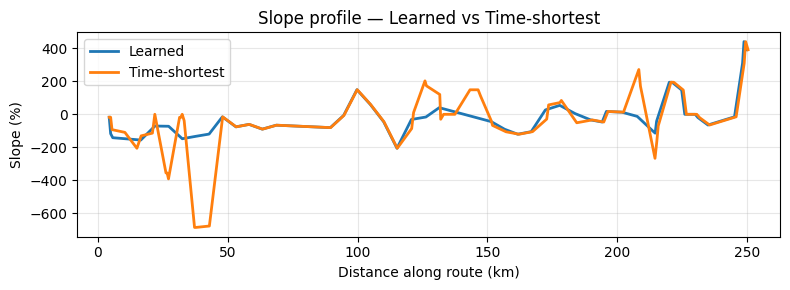

In [34]:
# Slope profile along the route (Learned vs Time-shortest)
import numpy as np, matplotlib.pyplot as plt, random

def _unnorm(series, idx):
    # 0:length_m, 1:time_s, 2:slope_pct (from earlier EDGE_NORM)
    if 'EDGE_NORM' in globals():
        mu, sig = EDGE_NORM
        return series * sig[idx] + mu[idx]
    return series

def route_profile(edge_ids):
    if not edge_ids:
        return np.array([0.0]), np.array([0.0])
    df = edges_gdf.loc[edge_ids]
    length_m = _unnorm(df["length_m"], 0).to_numpy()
    slope_pct = _unnorm(df["slope_pct"], 2).to_numpy()
    x_km = np.cumsum(length_m) / 1000.0
    # light smoothing for readability
    if len(slope_pct) >= 3:
        w = 3
        slope_pct = np.convolve(slope_pct, np.ones(w)/w, mode="same")
    return x_km, slope_pct

# pick a reasonable pair and compute both routes
valid_nodes = list(set(edges_gdf["u"]) & set(edges_gdf["v"]))
src_id, dst_id = random.sample(valid_nodes, 2)
_, pe_learned = astar_learned(src_id, dst_id, alpha_time=1.0)
_, pe_base    = shortest_edge_path(src_id, dst_id, weight="time_s")
print("edges learned/base:", len(pe_learned), len(pe_base), "  src→dst:", src_id, "→", dst_id)

# plot profiles
xL, yL = route_profile(pe_learned)
xB, yB = route_profile(pe_base)

plt.figure(figsize=(8,3))
plt.plot(xL, yL, label="Learned", linewidth=2)
plt.plot(xB, yB, label="Time-shortest", linewidth=2)
plt.xlabel("Distance along route (km)")
plt.ylabel("Slope (%)")
plt.title("Slope profile — Learned vs Time-shortest")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


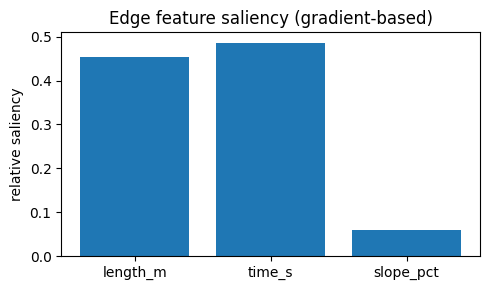

In [35]:
import torch, numpy as np, matplotlib.pyplot as plt, random

@torch.no_grad()
def _node_emb():
    return model(data).detach()

def edge_saliency_grad(sample_n=5000):
    device = data.x.device
    N = len(edges_gdf)
    idx = torch.tensor(random.sample(range(N), k=min(sample_n, N)), device=device)

    # u_idx_t, v_idx_t: (N,) node indices per edge
    # edge_attr_t: (N, 3) normalized edge features (length,time,slope)
    node_emb = _node_emb()

    u = u_idx_t[idx]; v = v_idx_t[idx]
    eattr = edge_attr_t[idx].clone().detach().requires_grad_(True)  # enable grads

    feats = torch.cat([node_emb[u], node_emb[v], eattr], dim=1)
    scores = model.edge_mlp(feats).squeeze(-1)   # (sample_n,)

    # aggregate (sum) to get a single scalar to backprop
    loss = scores.sum()
    loss.backward()

    grads = eattr.grad.detach().abs().mean(dim=0).cpu().numpy()  # (3,)
    grads = grads / (grads.sum() + 1e-9)
    return grads

gr_imp = edge_saliency_grad(sample_n=4000)

plt.figure(figsize=(5,3))
plt.bar(range(3), gr_imp, tick_label=["length_m","time_s","slope_pct"])
plt.ylabel("relative saliency")
plt.title("Edge feature saliency (gradient-based)")
plt.tight_layout(); plt.show()


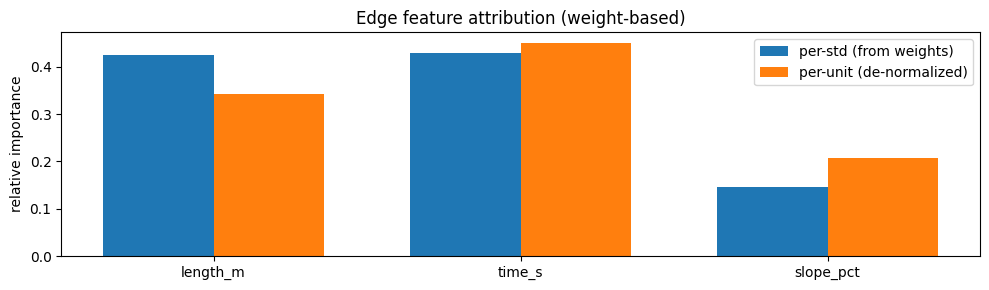

In [37]:
import torch, numpy as np, matplotlib.pyplot as plt

# feature names and how many edge features were concatenated
feature_names = ["length_m", "time_s", "slope_pct"]
in_edge = len(feature_names)

# grab first Linear layer of edge_mlp
first_linear = None
for m in model.edge_mlp.modules():
    if isinstance(m, torch.nn.Linear):
        first_linear = m
        break
assert first_linear is not None, "Couldn't find first Linear in edge_mlp"

W = first_linear.weight.detach().cpu().numpy()  # shape: [hidden, hid*2 + in_edge]
W_edge = W[:, -in_edge:]                        # last 3 columns = edge features

# importance: mean absolute weight per feature
imp_weight = np.mean(np.abs(W_edge), axis=0)
imp_weight = imp_weight / (imp_weight.sum() + 1e-9)

# scale to original units (per 1 unit, not per 1 std) if you normalized
imp_unit = None
if 'EDGE_NORM' in globals():
    mu, sig = EDGE_NORM  # [length_m, time_s, slope_pct] stds used in normalization
    # inputs were x' = (x - mu)/sig; per-unit effect ≈ per-std effect / sig
    imp_unit = imp_weight / (np.array(sig) + 1e-9)
    imp_unit = imp_unit / (imp_unit.sum() + 1e-9)

# plot
plt.figure(figsize=(10,3))
x = np.arange(in_edge)
plt.bar(x - 0.18, imp_weight, width=0.36, label="per-std (from weights)")
if imp_unit is not None:
    plt.bar(x + 0.18, imp_unit,  width=0.36, label="per-unit (de-normalized)")
plt.xticks(x, feature_names)
plt.ylabel("relative importance")
plt.title("Edge feature attribution (weight-based)")
plt.legend()
plt.tight_layout(); plt.show()
